In [1]:
"""
txt files in this directory contain intersection points for tennis court lines in videos.
These are used as input to PNP, to calculate the camera matrix for the video.
Since human pose estimates are given in camera coordinates, we then (using the center of the court as the origin)
transform the camera coordinates to court coordinates. 
"""
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
# Define intrinsic camera properties from a video file
def get_intrinsic_props(video_file):
    """
    Get the intrinsic camera properties from a video file. Here we use:
        - F_x = F_y = max(vid_width, vid_height)
        - C_x = vid_width / 2
        - C_y = vid_height / 2
    Returns: 
        - (F_x, F_y, C_x, C_y)
    """
    vid = cv2.VideoCapture(video_file)
    if not vid.isOpened():
        # Check exists
        if not os.path.exists(video_file):
            raise FileNotFoundError(f"Could not find video file {video_file}")
        raise ValueError(f"Could not open video file {video_file}")
    vid_width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
    vid_height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
    F_x = F_y = max(vid_width, vid_height)
    C_x = vid_width / 2
    C_y = vid_height / 2
    vid.release()
    return F_x, F_y, C_x, C_y


In [3]:
# solve PNP problem using the points defined in the txt file
def solve_PNP(video_file, txt_file):
    """
    Solve the PNP problem using the points defined in the txt file.
    Returns:
        - camera matrix
    """
    F_x, F_y, C_x, C_y = get_intrinsic_props(video_file)
    # Read the txt file
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    points = []
    for line in lines:
        x, y = line.split(";")
        points.append((float(x), float(y)))
    # define the 3D points
    """ 
    x ->
    y goes up
    z comes out of the screen (towards head from ground)
    |-|-------------|-|
    | |             | |
    | |             | |
    | |-------------| |
    | |      |      | |
    | |      |      | |
   -|-|------O------|-|-
    | |      |      | |
    | |      |      | |
    | |-------------| |
    | |             | |
    | |             | |
    |-|-------------|-|

            ^
            |
         |camera|
    """
    # Define lengths in meters from origin to key points
    BASELINE = 11.89
    SIDELINE = 5.49
    SERVICE_LINE = 6.4
    SINGLES_LINE = 4.11 
    obj_points = [
        (-SIDELINE, BASELINE),          # 1. top left - +
        (-SIDELINE, -BASELINE),         # 2. bottom left - - 
        (SIDELINE, -BASELINE),          # 3. bottom right + -
        (SIDELINE, BASELINE),           # 4. top right + +
        (-SINGLES_LINE, BASELINE),      # 5. Top left of singles line 
        (-SINGLES_LINE, -BASELINE),     # 6. Bottom left of singles line
        (SINGLES_LINE, -BASELINE),      # 7. Bottom right of singles line
        (SINGLES_LINE, BASELINE),       # 8. Top right of singles line
        (-SINGLES_LINE, SERVICE_LINE),  # 9. Top left of service line
        (SINGLES_LINE, SERVICE_LINE),   # 10. Top right of service line
        (-SINGLES_LINE, -SERVICE_LINE), # 11. Bottom left service line
        (SINGLES_LINE, -SERVICE_LINE),  # 12. Bottom right service line
        (0, SERVICE_LINE),              # 13. Top middle service line
        (0, -SERVICE_LINE),             # 14. bottom middle service line
        (-SIDELINE, 0),                 # 15. Left net line
        (SIDELINE, 0),                  # 16. Right net line
    ]
    # add a column of zeros to the object points (z-coordinate)
    obj_points = np.array(obj_points, dtype=np.float32)
    obj_points = np.hstack((obj_points, np.zeros((obj_points.shape[0], 1), dtype=np.float32)))

    # solve the PNP problem
    obj_points = np.array(obj_points, dtype=np.float32)
    points = np.array(points, dtype=np.float32)
    # Fill the intrinsic camera matrix (initial guess)
    camera_matrix = np.zeros((3, 3), dtype=np.float32)
    camera_matrix[0, 0] = F_x
    camera_matrix[1, 1] = F_y
    camera_matrix[0, 2] = C_x
    camera_matrix[1, 2] = C_y
    camera_matrix[2, 2] = 1
    dist_coeffs = np.zeros((4, 1), dtype=np.float32)
    image_size = (1920, 1080)
    _, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera([obj_points], [points], image_size, camera_matrix, dist_coeffs, flags=cv2.CALIB_USE_INTRINSIC_GUESS)
    rvec = (rvecs[0])
    tvec = (tvecs[0])

    return cameraMatrix, rvec, tvec, lines


In [4]:
# Test
cam, rvec, tvec, _ = solve_PNP("../data/full_clips/run_backhand.mp4", "../data/court_lines/run_backhand.txt")
print("Camera matrix: \n", cam)
print("Rotation vector: \n", rvec)
print("Translation vector: \n", tvec)

Camera matrix: 
 [[3.38216124e+03 0.00000000e+00 1.00404860e+03]
 [0.00000000e+00 1.98037927e+03 6.41018140e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation vector: 
 [[ 2.18924091]
 [-0.00722999]
 [-0.00614902]]
Translation vector: 
 [[-0.1283768 ]
 [-3.3464319 ]
 [33.57094928]]


In [5]:
import numpy as np

def pixel_to_court_coords(x, y, filename=None, K=None, rvec=None, tvec=None, lines=None):
    # TODO: use filename for court txt as well!
    if filename is not None:
        K, rvec, tvec, lines = solve_PNP(f"../data/full_clips/{filename}.mp4", f"../data/court_lines/run_backhand.txt") 
    elif K is None or rvec is None or tvec is None:
        raise ValueError("Must provide either filename or K, rvec, tvec")
    K_inv = np.linalg.inv(K)
    R = cv2.Rodrigues(rvec)[0] # rotation matrix
    t = tvec.reshape(3)

    # Convert the pixel to camera coordinates (ray in camera coordinates)
    pixel = np.array([x, y, 1]) 
    camera_coords = K_inv @ pixel  # This is essentially a ray in camera coordinates

    # Transform the ray from camera coordinates to world coordinates
    # We need to apply the inverse of the rotation matrix R and translation vector t

    # Convert to homogeneous coordinates in camera frame
    camera_coords_homogeneous = np.append(camera_coords, [1])

    # The ray in world coordinates
    ray_world = R.T @ (camera_coords - t)

    # The plane equation Z = 0 (in world coordinates)
    # The parametric equation of the ray: P = O + t * D
    # Where P is the point on the ray, O is the origin (camera position), and D is the direction (ray)
    # We need to find t where P_z = 0 (Z coordinate is 0)

    # Camera origin in world coordinates
    camera_origin_world = -R.T @ t

    # Direction of the ray in world coordinates
    ray_direction_world = ray_world - camera_origin_world

    # Calculate the parameter t for the plane Z=0
    t_intersect = -camera_origin_world[2] / ray_direction_world[2]

    # The 3D point of intersection on the plane Z=0
    intersection_world = camera_origin_world + t_intersect * ray_direction_world

    return intersection_world[:2]


3.6483409937998585 -12.49830403782154


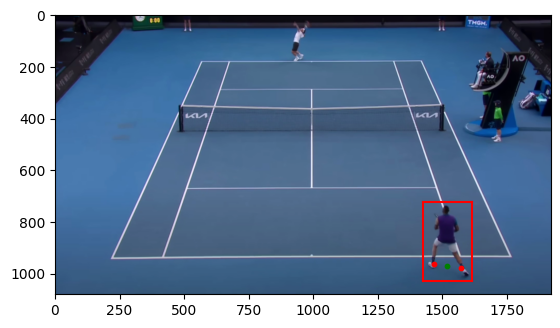

In [6]:
import json
# Get the player's pose in court coordinates
"""
We first compute the 2D position of the player's root projected onto the ground (center of two ankles), then
transform the location into court coordinates using the inverse camera projection. 

Ankles are joints 15 and 16 in the pose estimation. (15 - left ankle, 16 - right ankle)
"""

filename = "return"

# load the 2D pose from data/pose_estimations
with open(f"../data/pose_estimations/{filename}.json", 'r') as f:
    pose = json.load(f)

# pick a frame
frame = 80
pose = pose[frame]
if pose['frame'] != frame:
    raise ValueError("Frame number does not match")

left_ankle = (pose['x15'], pose['y15'])
right_ankle = (pose['x16'], pose['y16'])

# correct the pose locations by accounting for cropped video dimensions
with open(f"../data/cropped_clips/{filename}.json", "r") as f:
    crop = json.load(f)
crop = crop[frame]
if crop['frame'] != frame:
    raise ValueError("Frame number does not match")
left_ankle = (left_ankle[0] + crop['x1'], left_ankle[1] + crop['y1'])
right_ankle = (right_ankle[0] + crop['x1'], right_ankle[1] + crop['y1'])

# TEST ONLY: Get the original video, and draw the points
vid = cv2.VideoCapture(f"../data/full_clips/{filename}.mp4")
if not vid.isOpened():
    raise ValueError("Could not open video file")
vid.set(cv2.CAP_PROP_POS_FRAMES, frame)
ret, img = vid.read()
if not ret:
    raise ValueError("Could not read frame")
vid.release()


# work out dude's center point
# NOTE: This is pretty rough, but it's a start
center = ((left_ankle[0] + right_ankle[0]) / 2, (left_ankle[1] + right_ankle[1]) / 2)

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.scatter(left_ankle[0], left_ankle[1], c='r', s=10)
ax.scatter(right_ankle[0], right_ankle[1], c='r', s=10)
ax.scatter(center[0], center[1], c='g', s=10)

# draw the crop box
x1, y1, x2, y2 = crop['x1'], crop['y1'], crop['x2'], crop['y2']
ax.plot([x1, x2], [y1, y1], c='r')
ax.plot([x1, x2], [y2, y2], c='r')
ax.plot([x1, x1], [y1, y2], c='r')
ax.plot([x2, x2], [y1, y2], c='r')


court_x, court_y = pixel_to_court_coords(center[0], center[1], filename)

print(court_x, court_y)

# Now, need to alter the HybrIK mesh coordinates to match the court coordinates
# e.g -> estimate the player's global root position

# to fix global root orientation, use camera transformation

plt.show()

[ 9542.50095509 18985.72758139    28.36596852]
Pixel coordinates: [336.40666803 669.31356736]


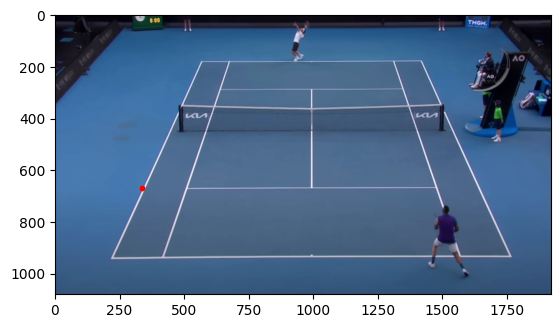

In [7]:


# WORLD TO PIXELS

camera_matrix, rvec, tvec, lines = solve_PNP(f"../data/full_clips/{filename}.mp4", f"../data/court_lines/run_backhand.txt")

BASELINE = 11.89
SIDELINE = 5.49
SERVICE_LINE = 6.4
SINGLES_LINE = 4.11 
R = cv2.Rodrigues(rvec)[0] # rotation matrix
tvec = tvec.reshape(3)  # translation vector

# Let's try to work out where the world point should be in the image
x = -SIDELINE
y = -SERVICE_LINE

world_coords = np.array([x, y, 0], dtype=np.float32)
# Project the world point into camera coordinates
camera_coords = R @ world_coords + tvec

# Project the camera coordinates into pixel coordinates
pixel_coords = camera_matrix @ camera_coords
print(pixel_coords)
pixel_coords = pixel_coords / pixel_coords[2]

print("Pixel coordinates:", pixel_coords[:2])

# plot that point on a frame of the video

# TEST ONLY: Get the original video, and draw the points
vid = cv2.VideoCapture(f"../data/full_clips/{filename}.mp4")
if not vid.isOpened():
    raise ValueError("Could not open video file")
vid.set(cv2.CAP_PROP_POS_FRAMES, frame)
ret, img = vid.read()
if not ret:
    raise ValueError("Could not read frame")
vid.release()

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.scatter(pixel_coords[0], pixel_coords[1], c='r', s=10)

plt.show()

In [9]:
# With that working - Can we convert the HybrIK mesh to court coordinates?
import time
import joblib
# Load the hybrik mesh
filename = "forehand"

# use first frame
frame = 0
mesh_file = f"{filename}_processed.pkl"
with open(f"../data/meshes/{mesh_file}", 'rb') as f:
    mesh = joblib.load(f)["00"]
# Mesh has: "00" : {root_orient, trans, pose_aa, beta, joints2d}

# load the 2D pose from data/pose_estimations
with open(f"../data/pose_estimations/{filename}.json", 'r') as f:
    pose = json.load(f)

trans = mesh["trans"]
# for each frame, compute the court coordinates of the ankle center -> change the x and y of trans to that
# Overlay the trans coordinates on each frame of the video and save as a new video

K, rvec, tvec, lines = solve_PNP(f"../data/full_clips/{filename}.mp4", f"../data/court_lines/run_backhand.txt")

vid = cv2.VideoCapture(f"../data/full_clips/{filename}.mp4")
if not vid.isOpened():
    raise ValueError("Could not open video file")
# Get the video properties
fps = vid.get(cv2.CAP_PROP_FPS)
width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
new_vid = cv2.VideoWriter(f"../data/translated/{filename}_trans.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
frame = 0
last_coords = []
imputed = 0
while True:
    ret, img = vid.read()
    if not ret:
        break
    # Get the trans of this frame
    frame_trans = trans[frame]
    # get the ankles of this frame
    frame_pose = pose[frame]



    if frame_pose['frame'] != frame:
        raise ValueError("Frame number does not match")

    left_ankle = (frame_pose['x15'], frame_pose['y15'])
    right_ankle = (frame_pose['x16'], frame_pose['y16'])

    # correct the pose locations by accounting for cropped video dimensions
    with open(f"../data/cropped_clips/{filename}.json", "r") as f:
        crop = json.load(f)
    crop = crop[frame]
    if crop['frame'] != frame:
        raise ValueError("Frame number does not match")
    left_ankle = (left_ankle[0] + crop['x1'], left_ankle[1] + crop['y1'])
    right_ankle = (right_ankle[0] + crop['x1'], right_ankle[1] + crop['y1'])



    center = ((left_ankle[0] + right_ankle[0]) / 2, (left_ankle[1] + right_ankle[1]) / 2)
    court_x, court_y = pixel_to_court_coords(center[0], center[1], K=K, rvec=rvec, tvec=tvec, lines=lines)
    
    # Sanity check -> how much has the player moved?
    if len(last_coords) > 0:
        diff = np.linalg.norm(np.array((court_x, court_y)) - np.array(last_coords[-1]))
        #NOTE: Magic Number
        if diff > 1: # more than 1 meter
            # TODO: GLAMR - Too hard to work out
            # For now. Use the moving av of up to 5 frames velocity to impute this frame
            ma_len = 5 if len(last_coords) > 5 else len(last_coords)
            vel = np.mean(np.diff(last_coords[-ma_len:], axis=0), axis=0)
            # Impute the position
            court_x, court_y = last_coords[-1] + vel
            imputed += 1

    last_coords.append((court_x, court_y))

    # update trans
    frame_trans[:2] = [court_x, court_y]
    trans[frame] = frame_trans

    # overlay the text onto the image
    text = f"({frame_trans[0]:.2}, {frame_trans[1]:.2}, {frame_trans[2]:.2})"
    img = cv2.putText(img, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # plot the center point
    img = cv2.circle(img, (int(center[0]), int(center[1])), 5, (0, 0, 255), -1)
    img = cv2.resize(img, (width, height))
    new_vid.write(img)
    frame += 1
vid.release()
new_vid.release()

# save the mesh back to the file
mesh['trans'] = trans
mesh = {"00": mesh}
mesh_file_out = f"{filename}_translated.pkl"
with open(f"../data/meshes/{mesh_file_out}", 'wb') as f:
    joblib.dump(mesh, f)

print(f"Imputed {imputed} frames out of {frame} frames")

Imputed 62 frames out of 150 frames
